# Enhancing Targeting Accuracy Using ML

## Project Overview

#### Context
Our client, a grocery retailer, sent out mailers in a marketing campaign for their new delivery club. This cost customers 100 USD per year for membership, and offered free grocery deliveries, rather than the normal cost of 10 USD per delivery.

For this, they sent mailers to their entire customer base (apart from a control group) but this proved expensive. For the next batch of communications they would like to save costs by only mailing customers that were likely to sign up.

Based upon the results of the last campaign and the customer data available, we will look to understand the probability of customers signing up for the delivery club. This would allow the client to mail a more targeted selection of customers, lowering costs, and improving ROI.

Let’s use Machine Learning to take on this task!


#### Actions

We firstly needed to compile the necessary data from tables in the database, gathering key customer metrics that may help predict delivery club membership.

Within our historical dataset from the last campaign, we found that 69% of customers did not sign up and 31% did. This tells us that while the data isn’t perfectly balanced at 50:50, it isn’t too imbalanced either. Even so, we make sure to not rely on classification accuracy alone when assessing results - also analysing Precision, Recall, and F1-Score.

As we are predicting a binary output, we tested four classification modelling approaches, namely:

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **K Nearest Neighbours (KNN)**

For each model, we will import the data in the same way but will need to pre-process the data based up the requirements of each particular algorithm. We will train & test each model, look to refine each to provide optimal performance, and then measure this predictive performance based on several metrics to give a well-rounded overview of which is best.

### Data Overview

We will be predicting the binary signup_flag metric from the campaign_data table in the client database.

The key variables hypothesised to predict this will come from the client database, namely the transactions table, the customer_details table, and the product_areas table.

We aggregated up customer data from the 3 months prior to the last campaign.

After this data pre-processing in Python, we have a dataset for modelling that contains the following fields…

### Modelling Overview

We will build a model that looks to accurately predict signup_flag, based upon the customer metrics listed above.

If that can be achieved, we can use this model to predict signup & signup probability for future campaigns. This information can be used to target those more likely to sign-up, reducing marketing costs and thus increasing ROI.

As we are predicting a binary output, we tested three classification modelling approaches, namely:

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **K Nearest Neighbours (KNN)**

## Logistic Regression

We utlise the scikit-learn library within Python to model our data using Logistic Regression. The code sections below are broken up into 5 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment
- Optimal Threshold Analysis

### Import required packages

In [15]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

### Data Import

Since we saved our modelling data as a pickle file, we import it. We ensure we remove the id column, and we also ensure our data is shuffled.

We also investigate the class balance of our dependent variable - which is important when assessing classification accuracy.

In [24]:
# import modelling data
data_for_model = pd.read_pickle(open("data/retail_store_classification_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

# assess class balance of dependent variable
data_for_model["signup_flag"].value_counts(normalize = True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

From the last step in the above code, we see that 69% of customers did not sign up and 31% did. This tells us that while the data isn’t perfectly balanced at 50:50, it isn’t too imbalanced either. Because of this, and as you will see, we make sure to not rely on classification accuracy alone when assessing results - also analysing Precision, Recall, and F1-Score.

### Data Preprocessing

For Logistic Regression we have certain data preprocessing steps that need to be addressed, including:

- Missing values in the data
- The effect of outliers
- Encoding categorical variables to numeric form
- Multicollinearity & Feature Selection

#### Missing values

The number of missing values in the data was extremely low, so instead of applying any imputation (i.e. mean, most common value) we will just remove those rows

In [29]:
# remove rows where values are missing
data_for_model.isna().sum()
data_for_model.dropna(how = "any", inplace = True)

#### Outliers

The ability for a Logistic Regression model to generalise well across all data can be hampered if there are outliers present. There is no right or wrong way to deal with outliers, but it is always something worth very careful consideration - just because a value is high or low, does not necessarily mean it should not be there!

In this code section, we use `.describe()` from Pandas to investigate the spread of values for each of our predictors. The results of this can be seen in the table below.

In [33]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


Based on this investigation, we see some max column values for several variables to be much higher than the median value.

This is for columns distance_from_store, total_sales, and total_items

For example, the median distance_to_store is 1.64 miles, but the maximum is over 400 miles!

Because of this, we apply some outlier removal in order to facilitate generalisation across the full dataset.

We do this using the “boxplot approach” where we remove any rows where the values within those columns are outside of the interquartile range multipli by 2.



In [36]:
# boxplot approach
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

for column in outlier_columns:
    
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace = True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


### Split Out Data For Modelling

In the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training. In this case, we have allocated 80% of the data for training, and the remaining 20% for validation. We make sure to add in the stratify parameter to ensure that both our training and test sets have the same proportion of customers who did, and did not, sign up for the delivery club - meaning we can be more confident in our assessment of predictive performance.

In [49]:
# split data into X and y objects for modelling
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

# split out training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Categorical Predictor Variables

In our dataset, we have one categorical variable gender which has values of “M” for Male, “F” for Female, and “U” for Unknown.

The Logistic Regression algorithm can’t deal with data in this format as it can’t assign any numerical meaning to it when looking to assess the relationship between the variable and the dependent variable.

As gender doesn’t have any explicit order to it, in other words, Male isn’t higher or lower than Female and vice versa - one appropriate approach is to apply One Hot Encoding to the categorical column.

One Hot Encoding can be thought of as a way to represent categorical variables as binary vectors, in other words, a set of new columns for each categorical value with either a 1 or a 0 saying whether that value is true or not for that observation. These new columns would go into our model as input variables, and the original column is discarded.

We also drop one of the new columns using the parameter drop = “first”. We do this to avoid the dummy variable trap where our newly created encoded columns perfectly predict each other - and we run the risk of breaking the assumption that there is no multicollinearity, a requirement or at least an important consideration for some models, Linear Regression being one of them! Multicollinearity occurs when two or more input variables are highly correlated with each other, it is a scenario we attempt to avoid as in short, while it won’t neccessarily affect the predictive accuracy of our model, it can make it difficult to trust the statistics around how well the model is performing, and how much each input variable is truly having.

In the code, we also make sure to apply fit_transform to the training set, but only transform to the test set. This means the One Hot Encoding logic will learn and apply the “rules” from the training data, but only apply them to the test data. This is important in order to avoid data leakage where the test set learns information about the training data, and means we can’t fully trust model performance metrics!

For ease, after we have applied One Hot Encoding, we turn our training and test objects back into Pandas Dataframes, with the column names applied.

In [51]:
# list of categorical variables that need encoding
categorical_vars = ["gender"]

# instantiate OHE class
one_hot_encoder = OneHotEncoder(sparse_output= False, drop = "first")

# apply OHE
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# extract feature names for encoded columns
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# turn objects back to pandas dataframe
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

### Feature Selection

Feature Selection is the process used to select the input variables that are most important to your Machine Learning task. It can be a very important addition or at least, consideration, in certain scenarios. The potential benefits of Feature Selection are:

- Improved Model Accuracy - eliminating noise can help true relationships stand out
- Lower Computational Cost - our model becomes faster to train, and faster to make predictions
- Explainability - understanding & explaining outputs for stakeholder & customers becomes much easier
- 
There are many, many ways to apply Feature Selection. These range from simple methods such as a Correlation Matrix showing variable relationships, to Univariate Testing which helps us understand statistical relationships between variables, and then to even more powerful approaches like Recursive Feature Elimination (RFE) which is an approach that starts with all input variables, and then iteratively removes those with the weakest relationships with the output variable.

For our task we applied a variation of Reursive Feature Elimination called Recursive Feature Elimination With Cross Validation (RFECV) where we split the data into many “chunks” and iteratively trains & validates models on each “chunk” seperately. This means that each time we assess different models with different variables included, or eliminated, the algorithm also knows how accurate each of those models was. From the suite of model scenarios that are created, the algorithm can determine which provided the best accuracy, and thus can infer the best set of input variables to use!

In [54]:
# instantiate RFECV & the model type to be utilised
clf = LogisticRegression(random_state = 42, max_iter = 1000)
feature_selector = RFECV(clf)

# fit RFECV onto our training & test data
fit = feature_selector.fit(X_train,y_train)

# extract & print the optimal number of features
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

# limit our training & test sets to only include the selected variables
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

Optimal number of features: 7


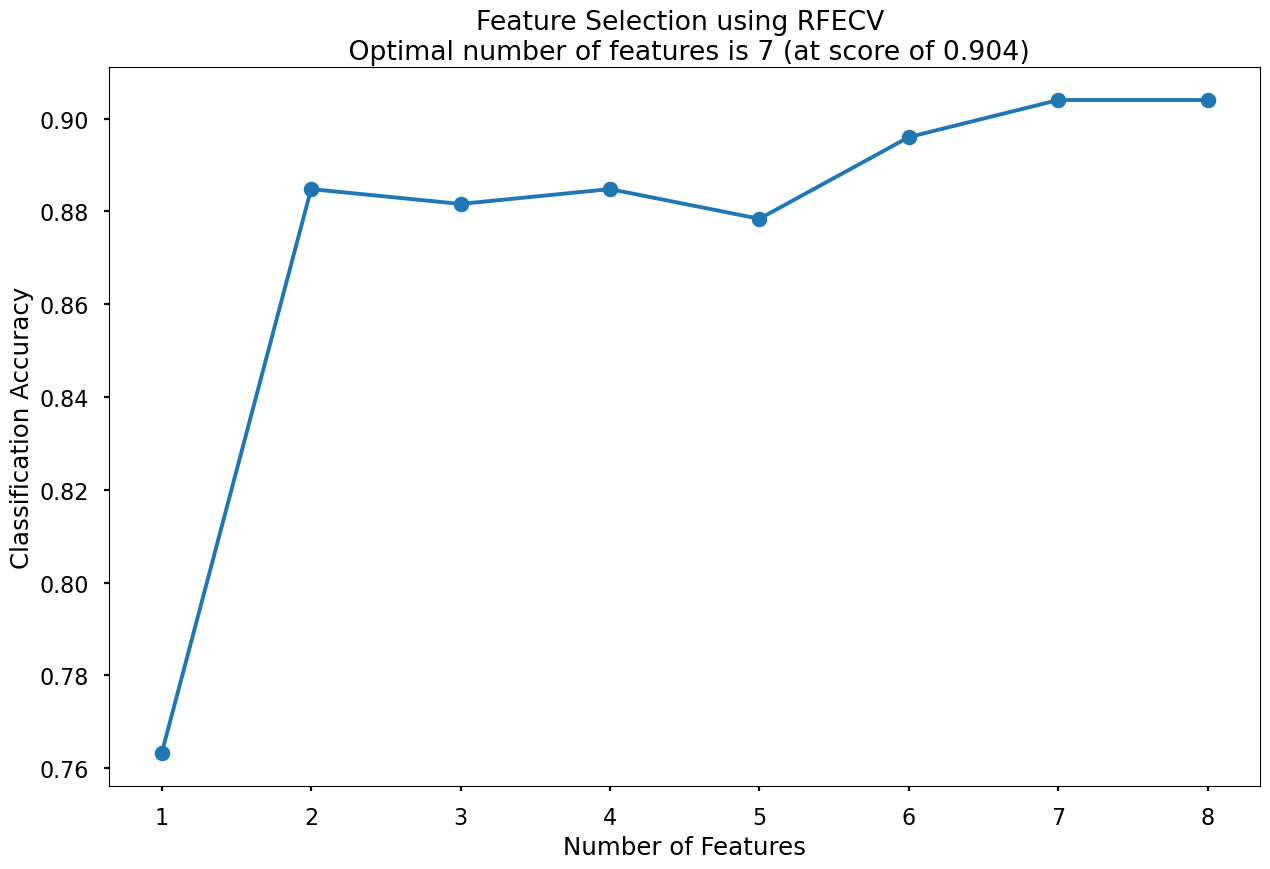

In [60]:
#visualizing the cross-validated classification accuracy with each potential number of features
plt.style.use('seaborn-v0_8-poster')
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Classification Accuracy")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFECV \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

The above plot shows us that the highest cross-validated classification accuracy (0.904) is when we include seven of our original input variables. The variable that has been dropped is total_sales but from the chart we can see that the difference is negligible. However, we will continue on with the selected seven!

### Model Training

Instantiating and training our Logistic Regression model is done using the below code. We use the random_state parameter to ensure reproducible results, meaning any refinements can be compared to past results. We also specify max_iter = 1000 to allow the solver more attempts at finding an optimal regression line, as the default value of 100 was not enough.

In [64]:
# instantiate our model object
clf = LogisticRegression(random_state = 42, max_iter = 1000)

# fit our model using our training & test sets
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Model Performance Assessment

#### Predict On The Test Set

To assess how well our model is predicting on new data - we use the trained model object (here called clf) and ask it to predict the signup_flag variable for the test set.

In the code below we create one object to hold the binary 1/0 predictions, and another to hold the actual prediction probabilities for the positive class.


In [68]:
# predict on the test set
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

#### Confusion Matrix

A Confusion Matrix provides us a visual way to understand how our predictions match up against the actual values for those test set observations.

The below code creates the Confusion Matrix using the confusion_matrix functionality from within scikit-learn and then plots it using matplotlib.

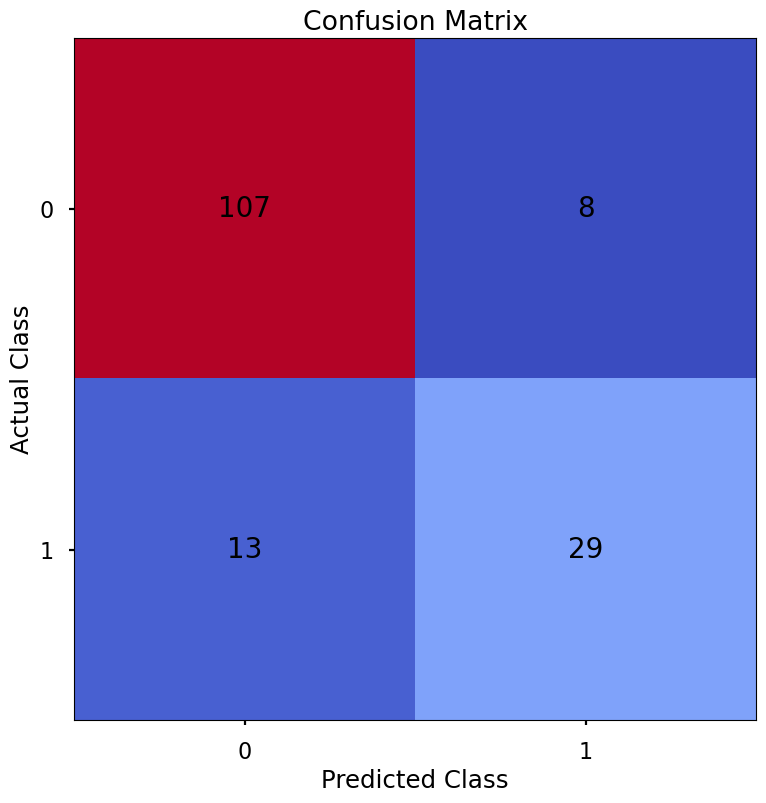

In [73]:
# create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# plot the confusion matrix
plt.style.use("seaborn-v0_8-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will next analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score which will help us assess how well our model has performed in reality.

#### Classification Performance Metrics

**Classification Accuracy**

Classification Accuracy is a metric that tells us of all predicted observations, what proportion did we correctly classify. This is very intuitive, but when dealing with imbalanced classes, can be misleading.

**Precision & Recall**

Precision is a metric that tells us of all observations that were predicted as positive, how many actually were positiveid

Recall is a metric that tells us of all positive observations, how many did we predict as posi

The tricky thing about Precision & Recall is that it is impossible to optimise both - it’s a zero-sum game. If you try to increase Precision, Recall decreases, and vice versa. Sometimes however it will make more sense to try and elevate one of them, in spite of the other. In the case of our rare-disease prediction like we’ve used in our example, perhaps it would be more important to optimise for Recall as we want to classify as many positive cases as possible. In saying this however, we don’t want to just classify every patient as having the disease, as that isn’t a great outcome either!

So - there is one more metric we will discuss & calculate, which is actually a combination of bot

**F1 Score**

F1-Score is a metric that essentially “combines” both Precision & Recall. Technically speaking, it is the harmonic mean of these two metrics. A good, or high, F1-Score comes when there is a balance between Precision & Recall, rather than a disparity between them.

Overall, optimising your model for F1-Score means that you’ll get a model that is working well for both positive & negative classifications rather than skewed towards one or the other. To return to the rare disease predictions, a high F1-Score would mean we’ve got a good balance between successfully predicting the disease when it’s present, and not predicting cases where it’s not present.

Using all of these metrics in combination gives a really good overview of the performance of a classification model, and gives us an understanding of the different scenarios & consideratios!


In the code below, we utilise in-built functionality from scikit-learn to calculate these four metrics.h…tive

In [90]:
# classification accuracy
accuracy_score_LR = accuracy_score(y_test, y_pred_class)

# precision
precision_score_LR = precision_score(y_test, y_pred_class)

# recall
recall_score_LR = recall_score(y_test, y_pred_class)

# f1-score
f1_score_LR = f1_score(y_test, y_pred_class)

print(f"accuracy_score_LR = {accuracy_score_LR}\nprecision_score_LR = {precision_score_LR}\nrecall_score_LR = {recall_score_LR}\nf1_score_LR = {f1_score_LR}")

accuracy_score_LR = 0.8662420382165605
precision_score_LR = 0.7837837837837838
recall_score_LR = 0.6904761904761905
f1_score_LR = 0.7341772151898734


Running the above Classification Performance Metrics code gives us:

- Classification Accuracy = 0.866 meaning we correctly predicted the class of 86.6% of test set observations
- Precision = 0.784 meaning that for our predicted delivery club signups, we were correct 78.4% of the time
- Recall = 0.69 meaning that of all actual delivery club signups, we predicted correctly 69% of the time
- F1-Score = 0.734

### Finding The Optimal Classification Threshold

By default, most pre-built classification models & algorithms will just use a 50% probability to discern between a positive class prediction (delivery club signup) and a negative class prediction (delivery club non-signup).

Just because 50% is the default threshold does not mean it is the best one for our task.

Here, we will test many potential classification thresholds, and plot the Precision, Recall & F1-Score, and find an optimal solution!

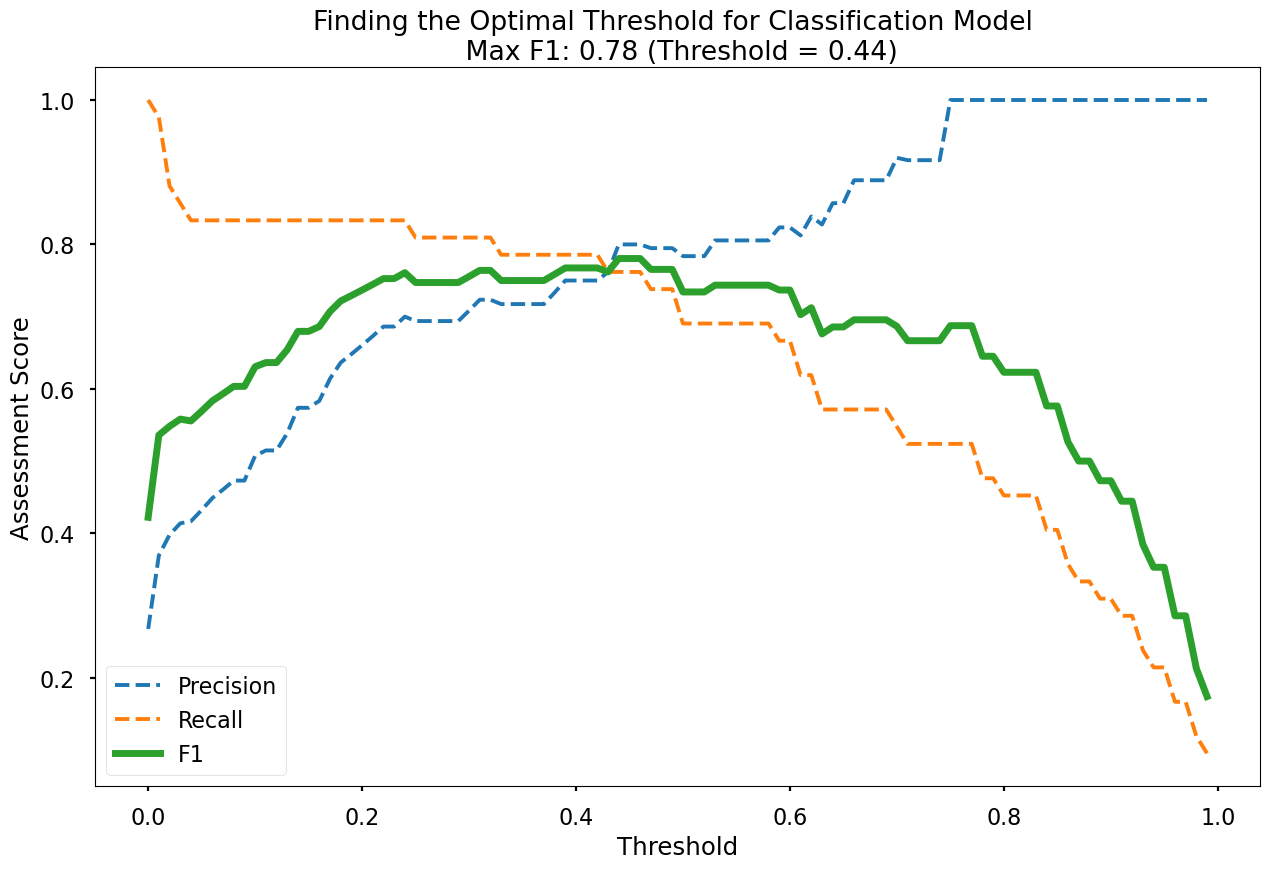

In [95]:
# set up the list of thresholds to loop through
thresholds = np.arange(0, 1, 0.01)

# create empty lists to append the results to
precision_scores = []
recall_scores = []
f1_scores = []

# loop through each threshold - fit the model - append the results
for threshold in thresholds:
    
    pred_class = (y_pred_prob >= threshold) * 1
    
    precision = precision_score(y_test, pred_class, zero_division = 0)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, pred_class)
    recall_scores.append(recall)
    
    f1 = f1_score(y_test, pred_class)
    f1_scores.append(f1)
    
# extract the optimal f1-score (and it's index)
max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)

# Visulizing the above results
plt.style.use("seaborn-v0_8-poster")
plt.plot(thresholds, precision_scores, label = "Precision", linestyle = "--")
plt.plot(thresholds, recall_scores, label = "Recall", linestyle = "--")
plt.plot(thresholds, f1_scores, label = "F1", linewidth = 5)
plt.title(f"Finding the Optimal Threshold for Classification Model \n Max F1: {round(max_f1,2)} (Threshold = {round(thresholds[max_f1_idx],2)})")
plt.xlabel("Threshold")
plt.ylabel("Assessment Score")
plt.legend(loc = "lower left")
plt.tight_layout()
plt.show()

Along the x-axis of the above plot we have the different classification thresholds that were testing. Along the y-axis we have the performance score for each of our three metrics. As per the legend, we have Precision as a blue dotted line, Recall as an orange dotted line, and F1-Score as a thick green line. You can see the interesting “zero-sum” relationship between Precision & Recall and you can see that the point where Precision & Recall meet is where F1-Score is maximised.

As you can see at the top of the plot, the optimal F1-Score for this model 0.78 and this is obtained at a classification threshold of 0.44. This is higher than the F1-Score of 0.734 that we achieved at the default classification threshold of 0.50!

## Decision Tree

We will again utlise the scikit-learn library within Python to model our data using a Decision Tree. The code sections below are broken up into 6 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment
- Tree Visualisation
- Decision Tree Regularisation


### Import Required Packages

In [100]:
# import required packages
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

### Data Import

In [103]:
# import modelling data
data_for_model = pd.read_pickle(open("data/retail_store_classification_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

# assess class balance of dependent variable
data_for_model["signup_flag"].value_counts(normalize = True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

### Data Preprocessing

While Logistic Regression is susceptible to the effects of outliers, and highly correlated input variables - Decision Trees are not, so the required preprocessing here is lighter. We still however will put in place logic for:

- Missing values in the data
- Encoding categorical variables to numeric form

#### Missing values

The number of missing values in the data was extremely low, so instead of applying any imputation (i.e. mean, most common value) we will just remove those rows.

In [109]:
# remove rows where values are missing
data_for_model.isna().sum()
data_for_model.dropna(how = "any", inplace = True)

### Split Out Data For Modelling

In exactly the same way we did for Logistic Regression, in the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training.

In [112]:
# split data into X and y objects for modelling
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

# split out training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Catergortical Predictor Variables

In our dataset, we have one categorical variable gender which has values of “M” for Male, “F” for Female, and “U” for Unknown.

Just like the Logisitc Regression algorithm, the Decision Tree cannot deal with data in this format as it can’t assign any numerical meaning to it when looking to assess the relationship between the variable and the dependent variable.

As gender doesn’t have any explicit order to it, in other words, Male isn’t higher or lower than Female and vice versa - we would again apply One Hot Encoding to the categorical column.

In [117]:
# list of categorical variables that need encoding
categorical_vars = ["gender"]

# instantiate OHE class
one_hot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# apply OHE
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# extract feature names for encoded columns
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# turn objects back to pandas dataframe
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

### Model Training

Instantiating and training our Decision Tree model is done using the below code. We use the random_state parameter to ensure we get reproducible results, and this helps us understand any improvements in performance with changes to model hyperparameters.

In [120]:
# instantiate our model object
clf = DecisionTreeClassifier(random_state = 42, max_depth = 5)

# fit our model using our training & test sets
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

### Model Performance Assessment

#### Predict On The Test Set

Just like we did with Logistic Regression, to assess how well our model is predicting on new data - we use the trained model object (here called clf) and ask it to predict the signup_flag variable for the test set.

In the code below we create one object to hold the binary 1/0 predictions, and another to hold the actual prediction probabilities for the positive class.

In [123]:
# predict on the test set
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

#### Confusion Matrix

As we discussed in the above section applying Logistic Regression - a Confusion Matrix provides us a visual way to understand how our predictions match up against the actual values for those test set observations.

The below code creates the Confusion Matrix using the confusion_matrix functionality from within scikit-learn and then plots it using matplotlib.

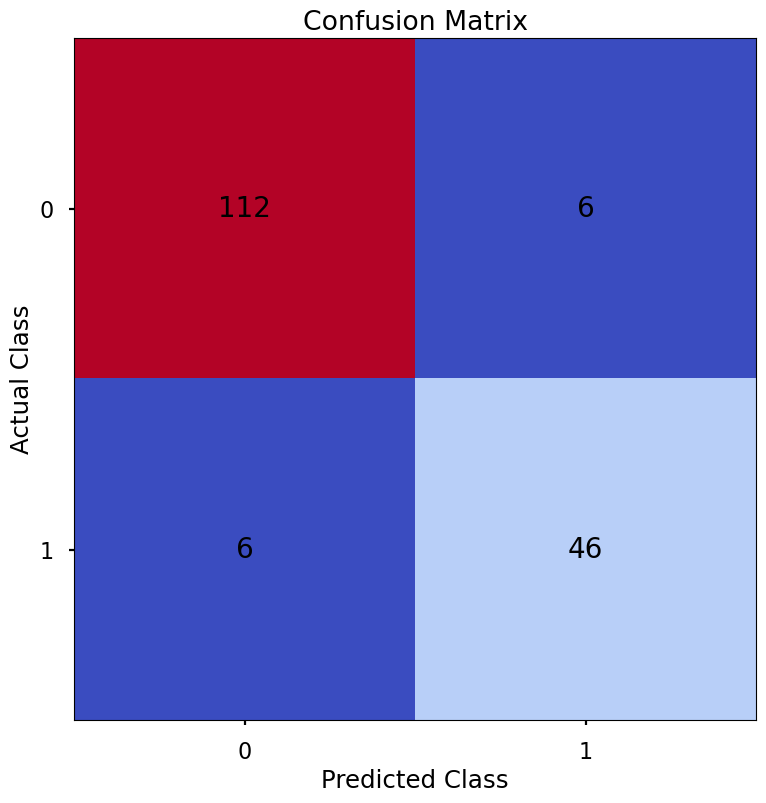

In [126]:
# create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# plot the confusion matrix
plt.style.use("seaborn-v0_8-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will again analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score as they will help us assess how well our model has performed from different points of view.

#### Classification Performance Metrics

**Accuracy, Precision, Recall & F1-Score**

For details on these performance metrics, please see the above section on Logistic Regression. Using all four of these metrics in combination gives a really good overview of the performance of a classification model, and gives us an understanding of the different scenarios & considerations!

In the code below, we utilise in-built functionality from scikit-learn to calculate these four metrics.

In [130]:
# classification accuracy
accuracy_score_DT = accuracy_score(y_test, y_pred_class)

# precision
precision_score_DT = precision_score(y_test, y_pred_class)

# recall
recall_score_DT = recall_score(y_test, y_pred_class)

# f1-score
f1_score_DT = f1_score(y_test, y_pred_class)

print(f"accuracy_score_DT = {accuracy_score_DT}\nprecision_score_DT = {precision_score_DT}\nrecall_score_DT = {recall_score_DT}\nf1_score_DT = {f1_score_DT}")

accuracy_score_DT = 0.9294117647058824
precision_score_DT = 0.8846153846153846
recall_score_DT = 0.8846153846153846
f1_score_DT = 0.8846153846153846


Running this code gives us:

- Classification Accuracy = 0.929 meaning we correctly predicted the class of 92.9% of test set observations
- Precision = 0.885 meaning that for our predicted delivery club signups, we were correct 88.5% of the time
- Recall = 0.885 meaning that of all actual delivery club signups, we predicted correctly 88.5% of the time
- F1-Score = 0.885

These are all higher than what we saw when applying Logistic Regression, even after we had optimised the classification threshold!

### Visulizing The Decision Tree

To see the decisions that have been made in the tree, we can use the plot_tree functionality that we imported from scikit-learn. To do this, we use the below code:

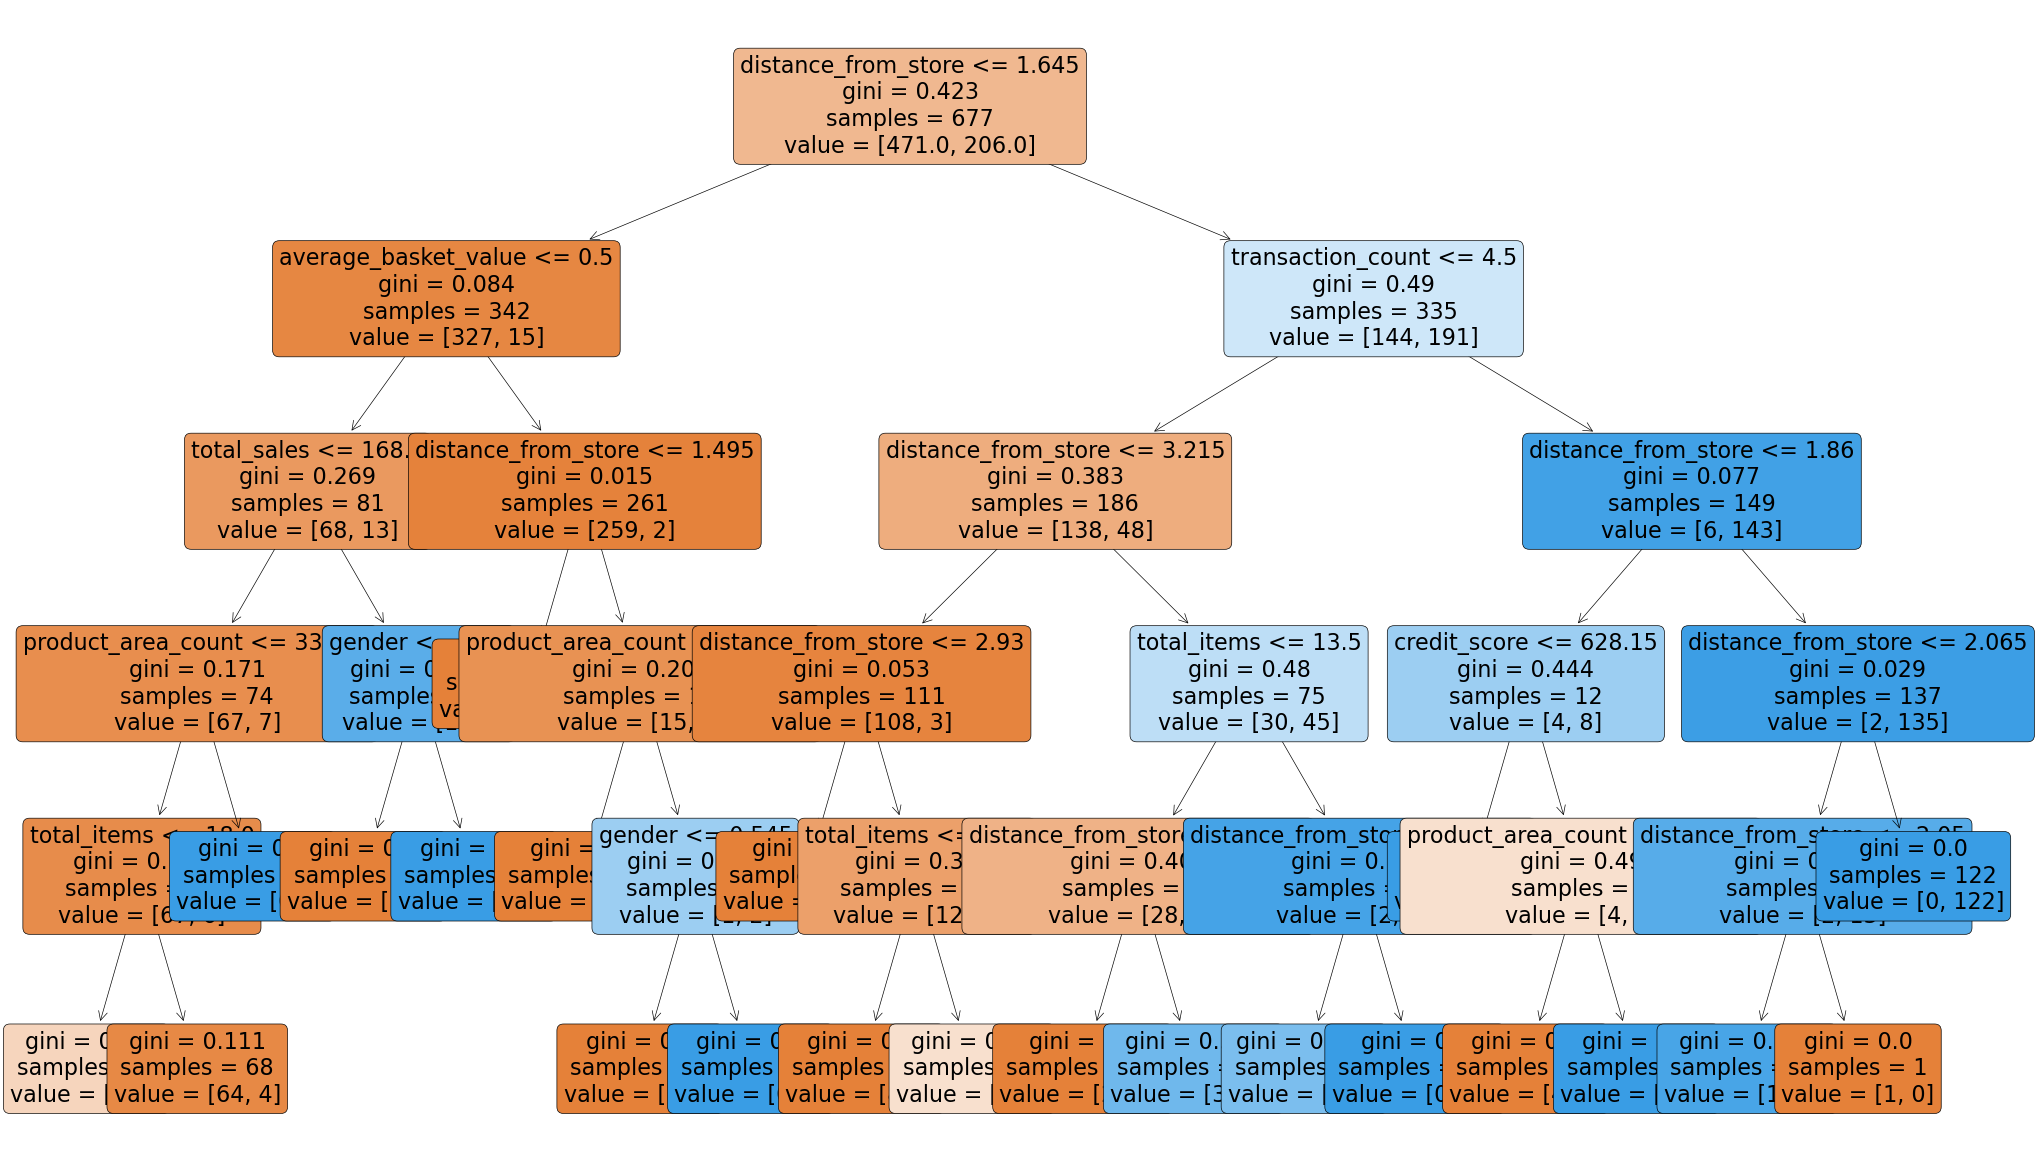

In [136]:
# plot the nodes of the decision tree
plt.figure(figsize=(25,15))
tree = plot_tree(clf,
                 feature_names = X.columns,
                 filled = True,
                 rounded = True,
                 fontsize = 16)

This is a powerful visual, and one that can be shown to stakeholders in the business to ensure they understand exactly what is driving the predictions.

One interesting thing to note is that the very first split appears to be using the variable distance from store so it would seem that this is a very important variable when it comes to predicting signups to the delivery club!

### Decision Tree Regularisation

Decision Tree’s can be prone to over-fitting, in other words, without any limits on their splitting, they will end up learning the training data perfectly. We would much prefer our model to have a more generalised set of rules, as this will be more robust & reliable when making predictions on new data.

One effective method of avoiding this over-fitting, is to apply a max depth to the Decision Tree, meaning we only allow it to split the data a certain number of times before it is required to stop.

We initially trained our model with a placeholder depth of 5, but unfortunately, we don’t necessarily know the optimal number for this. Below we will loop over a variety of values and assess which gives us the best predictive performance!

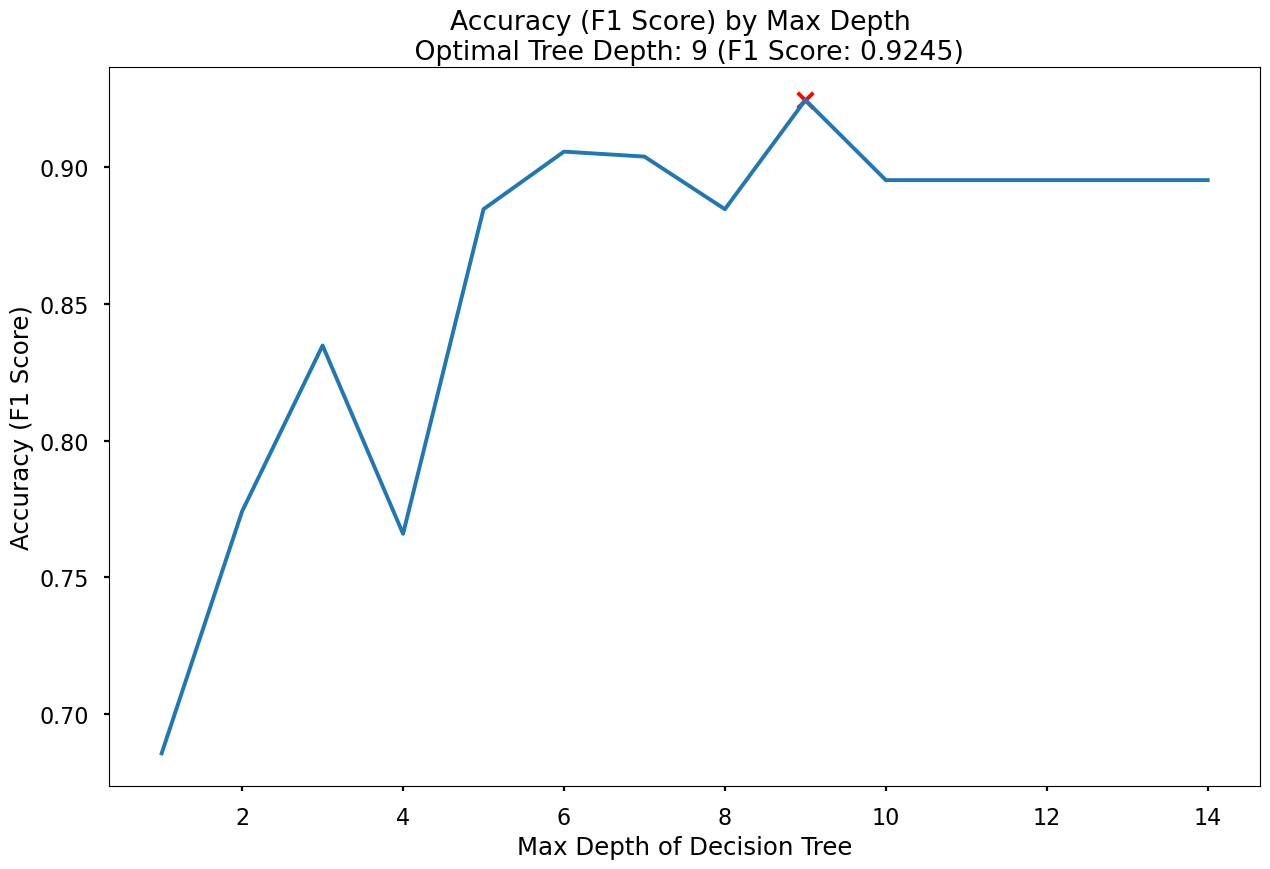

In [140]:
# finding the best max_depth

# set up range for search, and empty list to append accuracy scores to
max_depth_list = list(range(1,15))
accuracy_scores = []

# loop through each possible depth, train and validate model, append test set f1-score
for depth in max_depth_list:
    
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test,y_pred)
    accuracy_scores.append(accuracy)
    
# store max accuracy, and optimal depth    
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_idx]

# plot accuracy by max depth
plt.plot(max_depth_list,accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker = "x", color = "red")
plt.title(f"Accuracy (F1 Score) by Max Depth \n Optimal Tree Depth: {optimal_depth} (F1 Score: {round(max_accuracy,4)})")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Accuracy (F1 Score)")
plt.tight_layout()
plt.show()

In the plot we can see that the maximum F1-Score on the test set is found when applying a max_depth value of 9 which takes our F1-Score up to 0.925

## Random Forest

We will again utlise the scikit-learn library within Python to model our data using a Random Forest. The code sections below are broken up into 4 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment

### Import Required Packages

In [145]:
# import required packages
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [147]:
# import modelling data
data_for_model = pd.read_pickle(open("data/retail_store_classification_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

# assess class balance of dependent variable
data_for_model["signup_flag"].value_counts(normalize = True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

### Data Preprocessing

While Logistic Regression is susceptible to the effects of outliers, and highly correlated input variables - Decision Trees are not, so the required preprocessing here is lighter. We still however will put in place logic for:

- Missing values in the data
- Encoding categorical variables to numeric form

#### Missing values

The number of missing values in the data was extremely low, so instead of applying any imputation (i.e. mean, most common value) we will just remove those rows. Again, this is exactly the same process we ran for Logistic Regression & the Decision Tree.

In [157]:
# remove rows where values are missing
data_for_model.isna().sum()
data_for_model.dropna(how = "any", inplace = True)

### Split Out Data For Modelling

In exactly the same way we did for both Logistic Regression & our Decision Tree, in the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training. In this case, we have allocated 80% of the data for training, and the remaining 20% for validation. Again, we make sure to add in the stratify parameter to ensure that both our training and test sets have the same proportion of customers who did, and did not, sign up for the delivery club - meaning we can be more confident in our assessment of predictive performance.

In [160]:
# split data into X and y objects for modelling
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

# split out training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Categorical Predictor Variables

In our dataset, we have one categorical variable gender which has values of “M” for Male, “F” for Female, and “U” for Unknown.

Just like the Logistic Regression algorithm, Random Forests cannot deal with data in this format as it can’t assign any numerical meaning to it when looking to assess the relationship between the variable and the dependent variable.

As gender doesn’t have any explicit order to it, in other words, Male isn’t higher or lower than Female and vice versa - we would again apply One Hot Encoding to the categorical column.

In [163]:
# list of categorical variables that need encoding
categorical_vars = ["gender"]

# instantiate OHE class
one_hot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# apply OHE
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# extract feature names for encoded columns
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# turn objects back to pandas dataframe
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)


### Model Training

Instantiating and training our Random Forest model is done using the below code. We use the random_state parameter to ensure we get reproducible results, and this helps us understand any improvements in performance with changes to model hyperparameters.

We also look to build more Decision Trees in the Random Forest (500) than would be done using the default value of 100.

Lastly, since the default scikit-learn implementation of Random Forests does not limit the number of randomly selected variables offered up for splitting at each split point in each Decision Tree - we put this in place using the max_features parameter. This can always be refined later through testing, or through an approach such as gridsearch.

In [166]:
# instantiate our model object
clf = RandomForestClassifier(random_state = 42, n_estimators = 500, max_features = 5)

# fit our model using our training & test sets
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=500, random_state=42)

### Model Performance Assessment

#### Predict On The Test Set

Just like we did with Logistic Regression & our Decision Tree, to assess how well our model is predicting on new data - we use the trained model object (here called clf) and ask it to predict the signup_flag variable for the test set.

In the code below we create one object to hold the binary 1/0 predictions, and another to hold the actual prediction probabilities for the positive class.

In [169]:
# predict on the test set
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

#### Confusion Matrix

As we discussed in the above sections - a Confusion Matrix provides us a visual way to understand how our predictions match up against the actual values for those test set observations.

The below code creates the Confusion Matrix using the `confusion_matrix` functionality from within scikit-learn and then plots it using matplotlib.

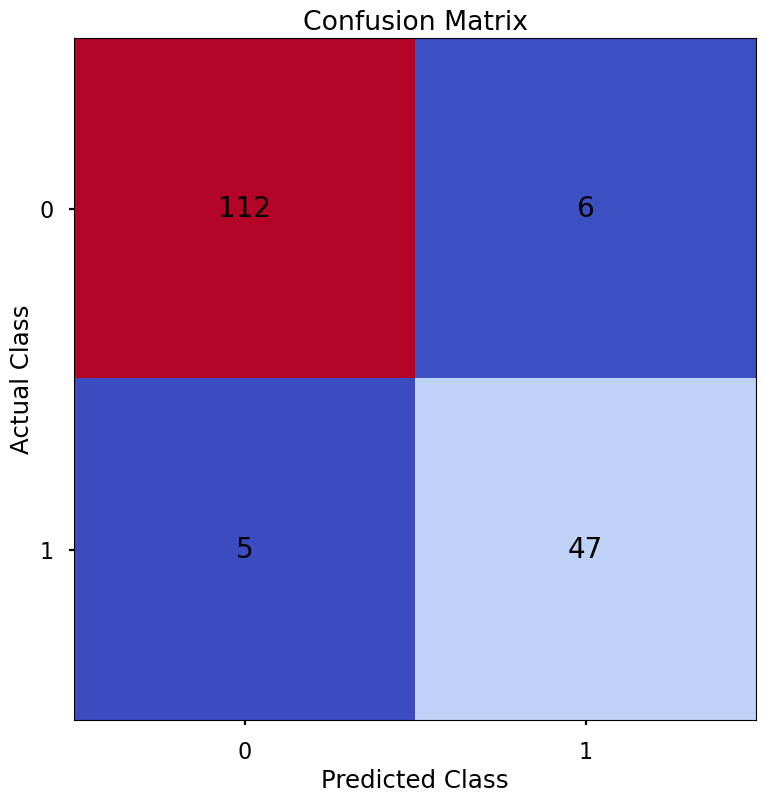

In [174]:
# create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# plot the confusion matrix
plt.style.use("seaborn-v0_8-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will again analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score as they will help us assess how well our model has performed from different points of view.

#### Classification Performance Metrics

**Accuracy, Precision, Recall & F1-Score**

For details on these performance metrics, please see the above section on Logistic Regression. Using all four of these metrics in combination gives a really good overview of the performance of a classification model, and gives us an understanding of the different scenarios & considerations!

In the code below, we utilise in-built functionality from scikit-learn to calculate these four metrics.

In [178]:
# classification accuracy
accuracy_score_RF = accuracy_score(y_test, y_pred_class)

# precision
precision_score_RF = precision_score(y_test, y_pred_class)

# recall
recall_score_RF = recall_score(y_test, y_pred_class)

# f1-score
f1_score_RF = f1_score(y_test, y_pred_class)

print(f"accuracy_score_RF = {accuracy_score_RF}\nprecision_score_RF = {precision_score_RF}\nrecall_score_RF = {recall_score_RF}\nf1_score_RF = {f1_score_RF}")

accuracy_score_RF = 0.9352941176470588
precision_score_RF = 0.8867924528301887
recall_score_RF = 0.9038461538461539
f1_score_RF = 0.8952380952380953


Running the above Classification Performance Metrics code gives us:

- Classification Accuracy = 0.935 meaning we correctly predicted the class of 93.5% of test set observations
- Precision = 0.887 meaning that for our predicted delivery club signups, we were correct 88.7% of the time
- Recall = 0.904 meaning that of all actual delivery club signups, we predicted correctly 90.4% of the time
- F1-Score = 0.895

These are all higher than what we saw when applying `Logistic Regression`, and marginally higher than what we got from our `Decision Tree`. If we are after out and out accuracy then this would be the best model to choose. If we were happier with a simpler, easier explain model, but that had almost the same performance - then we may choose the `Decision Tree` instead!

### Feature Importance

Random Forests are an ensemble model, made up of many, many Decision Trees, each of which is different due to the randomness of the data being provided, and the random selection of input variables available at each potential split point.

Because of this, we end up with a powerful and robust model, but because of the random or different nature of all these Decision trees - the model gives us a unique insight into how important each of our input variables are to the overall model.

As we’re using random samples of data, and input variables for each Decision Tree - there are many scenarios where certain input variables are being held back and this enables us a way to compare how accurate the models predictions are if that variable is or isn’t present.

So, at a high level, in a Random Forest we can measure importance by asking How much would accuracy decrease if a specific input variable was removed or randomised?

If this decrease in performance, or accuracy, is large, then we’d deem that input variable to be quite important, and if we see only a small decrease in accuracy, then we’d conclude that the variable is of less importance.

At a high level, there are two common ways to tackle this. The first, often just called Feature Importance is where we find all nodes in the Decision Trees of the forest where a particular input variable is used to split the data and assess what the gini impurity score (for a Classification problem) was before the split was made, and compare this to the gini impurity score after the split was made. We can take the average of these improvements across all Decision Trees in the Random Forest to get a score that tells us how much better we’re making the model by using that input variable.

If we do this for each of our input variables, we can compare these scores and understand which is adding the most value to the predictive power of the model!

The other approach, often called Permutation Importance cleverly uses some data that has gone unused at when random samples are selected for each Decision Tree (this stage is called “bootstrap sampling” or “bootstrapping”)

These observations that were not randomly selected for each Decision Tree are known as Out of Bag observations and these can be used for testing the accuracy of each particular Decision Tree.

For each Decision Tree, all of the Out of Bag observations are gathered and then passed through. Once all of these observations have been run through the Decision Tree, we obtain a classification accuracy score for these predictions.

In order to understand the importance, we randomise the values within one of the input variables - a process that essentially destroys any relationship that might exist between that input variable and the output variable - and run that updated data through the Decision Tree again, obtaining a second accuracy score. The difference between the original accuracy and the new accuracy gives us a view on how important that particular variable is for predicting the output.

Permutation Importance is often preferred over Feature Importance which can at times inflate the importance of numerical features. Both are useful, and in most cases will give fairly similar results.

Let’s put them both in place, and plot the results…

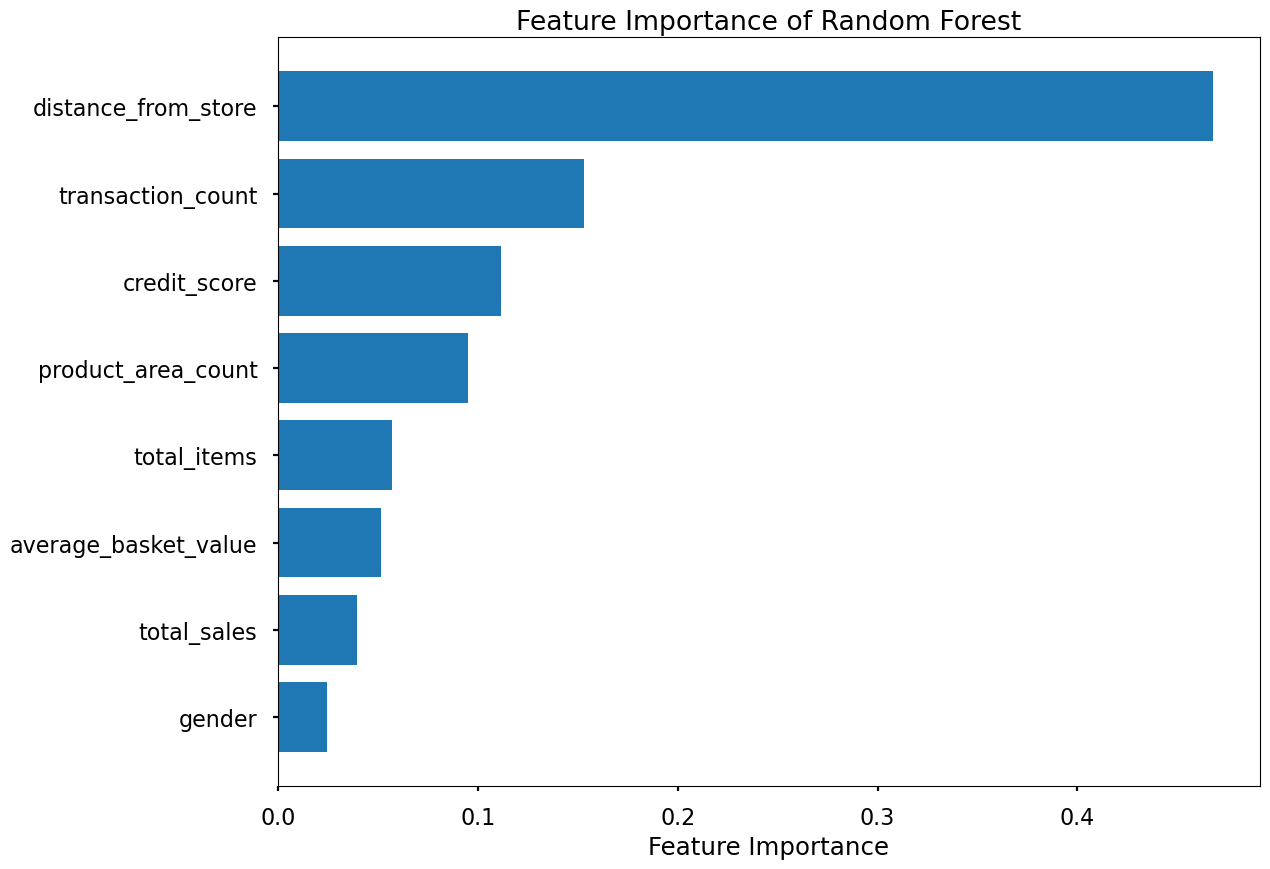

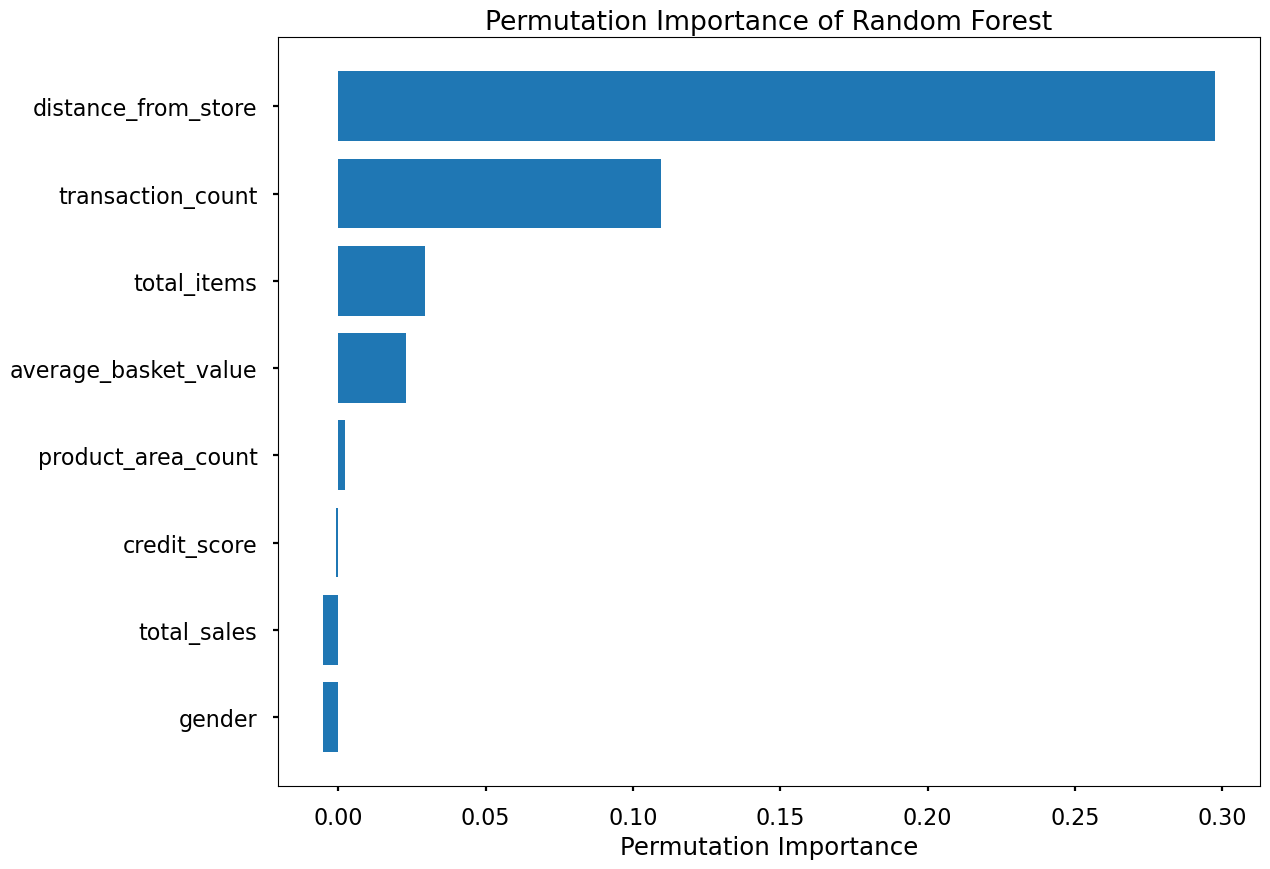

In [184]:
# calculate feature importance
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance], axis = 1)
feature_importance_summary.columns = ["input_variable","feature_importance"]
feature_importance_summary.sort_values(by = "feature_importance", inplace = True)

# plot feature importance
plt.barh(feature_importance_summary["input_variable"],feature_importance_summary["feature_importance"])
plt.title("Feature Importance of Random Forest")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

# calculate permutation importance
result = permutation_importance(clf, X_test, y_test, n_repeats = 10, random_state = 42)
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance], axis = 1)
permutation_importance_summary.columns = ["input_variable","permutation_importance"]
permutation_importance_summary.sort_values(by = "permutation_importance", inplace = True)

# plot permutation importance
plt.barh(permutation_importance_summary["input_variable"],permutation_importance_summary["permutation_importance"])
plt.title("Permutation Importance of Random Forest")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

The overall story from both approaches is very similar, in that by far, the most important or impactful input variables are distance_from_store and transaction_count

Surprisingly, average_basket_size was not as important as hypothesised.

There are slight differences in the order or “importance” for the remaining variables but overall they have provided similar findings.

In [ ]:
## K Nearest Neighbours

We utlise the scikit-learn library within Python to model our data using KNN. The code sections below are broken up into 5 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment
- Optimal Value For K

### Import Required Packages

In [189]:
# import required packages
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV

### Import Data

Again, since we saved our modelling data as a pickle file, we import it. We ensure we remove the id column, and we also ensure our data is shuffled.

As with the other approaches, we also investigate the class balance of our dependent variable - which is important when assessing classification accuracy.

In [192]:
# import modelling data
data_for_model = pd.read_pickle(open("data/retail_store_classification_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

# assess class balance of dependent variable
data_for_model["signup_flag"].value_counts(normalize = True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

From the last step in the above code, we see that 69% of customers did not sign up and 31% did. This tells us that while the data isn’t perfectly balanced at 50:50, it isn’t too imbalanced either. Because of this, and as you will see, we make sure to not rely on classification accuracy alone when assessing results - also analysing Precision, Recall, and F1-Score.

### Data Preprocessing

For KNN, as it is a distance based algorithm, we have certain data preprocessing steps that need to be addressed, including:

- Missing values in the data
- The effect of outliers
- Encoding categorical variables to numeric form
- Feature Scaling
- Feature Selection

#### Missing Values

The number of missing values in the data was extremely low, so instead of applying any imputation (i.e. mean, most common value) we will just remove those rows

In [203]:
# remove rows where values are missing
data_for_model.isna().sum()
data_for_model.dropna(how = "any", inplace = True)

#### Outliers

As KNN is a distance based algorithm, you could argue that if a data point is a long way away, then it will simply never be selected as one of the neighbours - and this is true - but outliers can still cause us problems here. The main issue we face is when we come to scale our input variables, a very important step for a distance based algorithm.

We don’t want any variables to be “bunched up” due to a single outlier value, as this will make it hard to compare their values to the other input variables. We should always investigate outliers rigorously - in this case we will simply remove them.

In this code section, just like we saw when applying Logistic Regression, we use `.describe()` from Pandas to investigate the spread of values for each of our predictors. The results of this can be seen in the table below.

In [207]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


Again, based on this investigation, we see some max column values for several variables to be much higher than the median value.

This is for columns distance_from_store, total_sales, and total_items

For example, the median distance_to_store is 1.64 miles, but the maximum is over 400 miles!

Because of this, we apply some outlier removal in order to facilitate generalisation across the full dataset.

We do this using the “boxplot approach” where we remove any rows where the values within those columns are outside of the interquartile range multiplied by 2.

In [210]:
outlier_investigation = data_for_model.describe()
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

# boxplot approach
for column in outlier_columns:
    
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace = True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


### Split Out Data For Modelling

In exactly the same way we’ve done for the other three models, in the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training. In this case, we have allocated 80% of the data for training, and the remaining 20% for validation. 

In [213]:
# split data into X and y objects for modelling
X = data_for_model.drop(["signup_flag"], axis = 1)
y = data_for_model["signup_flag"]

# split out training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Categorical Predictor Variables

As we saw when applying the other algorithms, in our dataset, we have one categorical variable gender which has values of “M” for Male, “F” for Female, and “U” for Unknown.

The KNN algorithm can’t deal with data in this format as it can’t assign any numerical meaning to it when looking to assess the relationship between the variable and the dependent variable.

As gender doesn’t have any explicit order to it, in other words, Male isn’t higher or lower than Female and vice versa - one appropriate approach is to apply One Hot Encoding to the categorical column. For more detsils on One Hot Encoding refer to Logistic Regression - Categorical Predictor Variables section.

For ease, after we have applied One Hot Encoding, we turn our training and test objects back into Pandas Dataframes, with the column names applied.

In [216]:
# list of categorical variables that need encoding
categorical_vars = ["gender"]

# instantiate OHE class
one_hot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# apply OHE
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# extract feature names for encoded columns
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# turn objects back to pandas dataframe
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

### Feature Scaling

As KNN is a distance based algorithm, in other words it is reliant on an understanding of how similar or different data points are across different dimensions in n-dimensional space, the application of Feature Scaling is extremely important.

Feature Scaling is where we force the values from different columns to exist on the same scale, in order to enchance the learning capabilities of the model. There are two common approaches for this, Standardisation, and Normalisation.

Standardisation rescales data to have a mean of 0, and a standard deviation of 1 - meaning most datapoints will most often fall between values of around -4 and +4.

Normalisation rescales datapoints so that they exist in a range between 0 and 1.

The below code uses the in-built MinMaxScaler functionality from scikit-learn to apply Normalisation to all of our input variables. The reason we choose Normalisation over Standardisation is that our scaled data will all exist between 0 and 1, and these will then be compatible with any categorical variables that we have encoded as 1’s and 0’s.

In [219]:
# create our scaler object
scale_norm = MinMaxScaler()

# normalise the training set (using fit_transform)
X_train = pd.DataFrame(scale_norm.fit_transform(X_train), columns = X_train.columns)

# normalise the test set (using transform only)
X_test = pd.DataFrame(scale_norm.transform(X_test), columns = X_test.columns)

### Feature Selection

As we discussed when applying Logistic Regression above - Feature Selection is the process used to select the input variables that are most important to your Machine Learning task. For more information around this, please see that section above.

When applying KNN, Feature Selection is an interesting topic. The algorithm is measuring the distance between data-points across all dimensions, where each dimension is one of our input variables. The algorithm treats each input variable as equally important, there isn’t really a concept of “feature importance” so the spread of data within an unimportant variable could have an effect on judging other data points as either “close” or “far”. If we had a lot of “unimportant” variables in our data, this could create a lot of noise for the algorithm to deal with, and we’d just see poor classification accuracy without really knowing why.

Having a high number of input variables also means the algorithm has to process a lot more information when processing distances between all of the data-points, so any way to reduce dimensionality is important from a computational perspective as well.

For our task here we are again going to apply Recursive Feature Elimination With Cross Validation (RFECV) which is an approach that starts with all input variables, and then iteratively removes those with the weakest relationships with the output variable. RFECV does this using Cross Validation, so splits the data into many “chunks” and iteratively trains & validates models on each “chunk” seperately. This means that each time we assess different models with different variables included, or eliminated, the algorithm also knows how accurate each of those models was. From the suite of model scenarios that are created, the algorithm can determine which provided the best accuracy, and thus can infer the best set of input variables to use!

Optimal number of features: 6


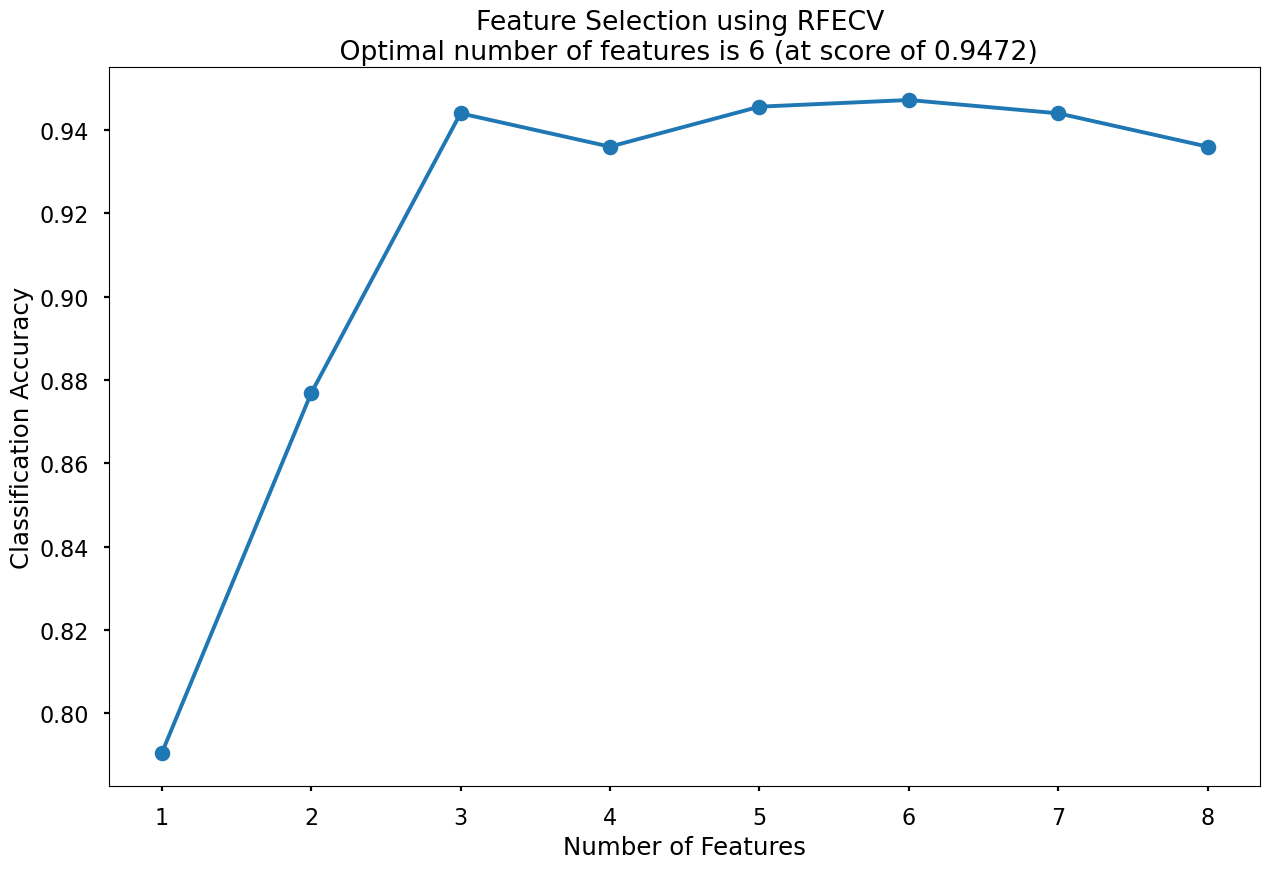

In [222]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
feature_selector = RFECV(clf)

# fit RFECV onto our training & test data
fit = feature_selector.fit(X_train,y_train)

# extract & print the optimal number of features
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

# limit our training & test sets to only include the selected variables
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# Visulizing the Feature Selection
plt.style.use('seaborn-v0_8-poster')
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Classification Accuracy")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFECV \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

### Model Training

Instantiating and training our KNN model is done using the below code. At this stage we will just use the default parameters, meaning that the algorithm:

Will use a value for k of 5, or in other words it will base classifications based upon the 5 nearest neighbours
Will use uniform weighting, or in other words an equal weighting to all 5 neighbours regardless of distance

In [225]:
# instantiate our model object
clf = KNeighborsClassifier()

# fit our model using our training & test sets
clf.fit(X_train, y_train)

KNeighborsClassifier()

### Model Performance Assessment

#### Predict On The Test Set

To assess how well our model is predicting on new data - we use the trained model object (here called clf) and ask it to predict the signup_flag variable for the test set.

In the code below we create one object to hold the binary 1/0 predictions, and another to hold the actual prediction probabilities for the positive class (which is based upon the majority class within the k nearest neighbours)

In [228]:
# predict on the test set
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

#### Confusion Matrix

As we’ve seen with all models so far, our Confusion Matrix provides us a visual way to understand how our predictions match up against the actual values for those test set observations.

The below code creates the Confusion Matrix using the confusion_matrix functionality from within scikit-learn and then plots it using matplotlib.

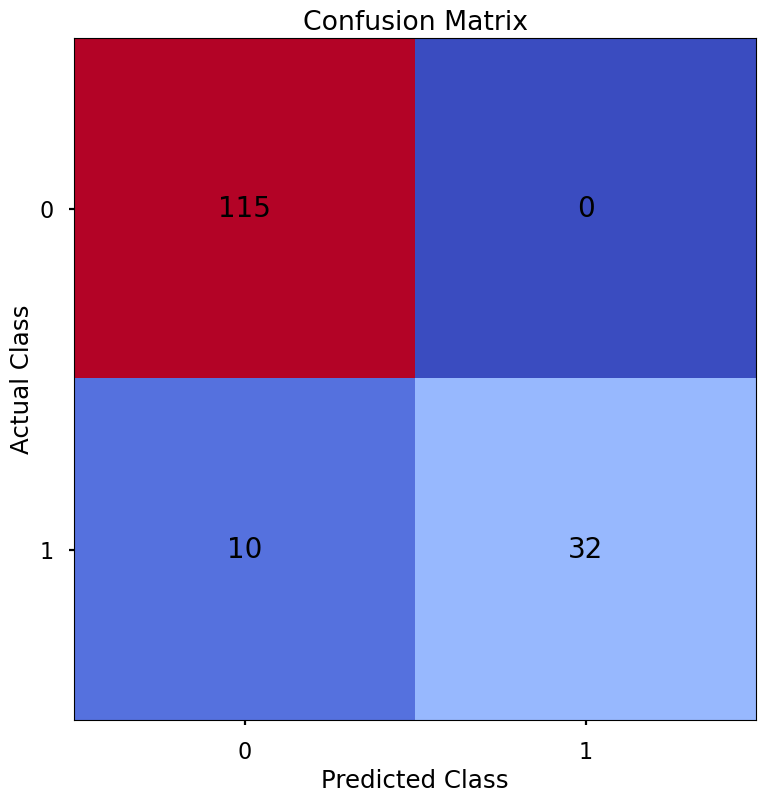

In [233]:
# create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# plot the confusion matrix
plt.style.use("seaborn-v0_8-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

The results here are interesting - all of the errors are where the model incorrectly classified delivery club signups as non-signups - the model made no errors when classifying non-signups non-signups.

Since the proportion of signups in our data was around 30:70 we will next analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score which will help us assess how well our model has performed in reality.

### Classification Performance Metrics

**Accuracy, Precision, Recall & F1-Score**

For details on these performance metrics, please see the above section on Logistic Regression. Using all four of these metrics in combination gives a really good overview of the performance of a classification model, and gives us an understanding of the different scenarios & considerations!

In the code below, we utilise in-built functionality from scikit-learn to calculate these four metrics.

In [237]:
# classification accuracy
accuracy_score_KNN = accuracy_score(y_test, y_pred_class)

# precision
precision_score_KNN = precision_score(y_test, y_pred_class)

# recall
recall_scoreKNN = recall_score(y_test, y_pred_class)

# f1-score
f1_score_KNN = f1_score(y_test, y_pred_class)

print(f"accuracy_score_KNN = {accuracy_score_RF}\nprecision_score_KNN = {precision_score_RF}\nrecall_score_KNN = {recall_score_RF}\nf1_score_KNN = {f1_score_RF}")

accuracy_score_KNN = 0.9352941176470588
precision_score_KNN = 0.8867924528301887
recall_score_KNN = 0.9038461538461539
f1_score_KNN = 0.8952380952380953


Running this code gives us:

- Classification Accuracy = 0.936 meaning we correctly predicted the class of 93.6% of test set observations
- Precision = 1.00 meaning that for our predicted delivery club signups, we were correct 100% of the time
- Recall = 0.762 meaning that of all actual delivery club signups, we predicted correctly 76.2% of the time
- F1-Score = 0.865

The KNN has obtained the highest overall Classification Accuracy & Precision, but the lower Recall score has penalised the F1-Score meaning that is actually lower than what was seen for both the Decision Tree & the Random Forest!

### Finding The Optimal Value for k

By default, the KNN algorithm within scikit-learn will use k = 5 meaning that classifications are based upon the five nearest neighbouring data-points in n-dimensional space.

Just because this is the default threshold does not mean it is the best one for our task.

Here, we will test many potential values for k, and plot the Precision, Recall & F1-Score, and find an optimal solution!

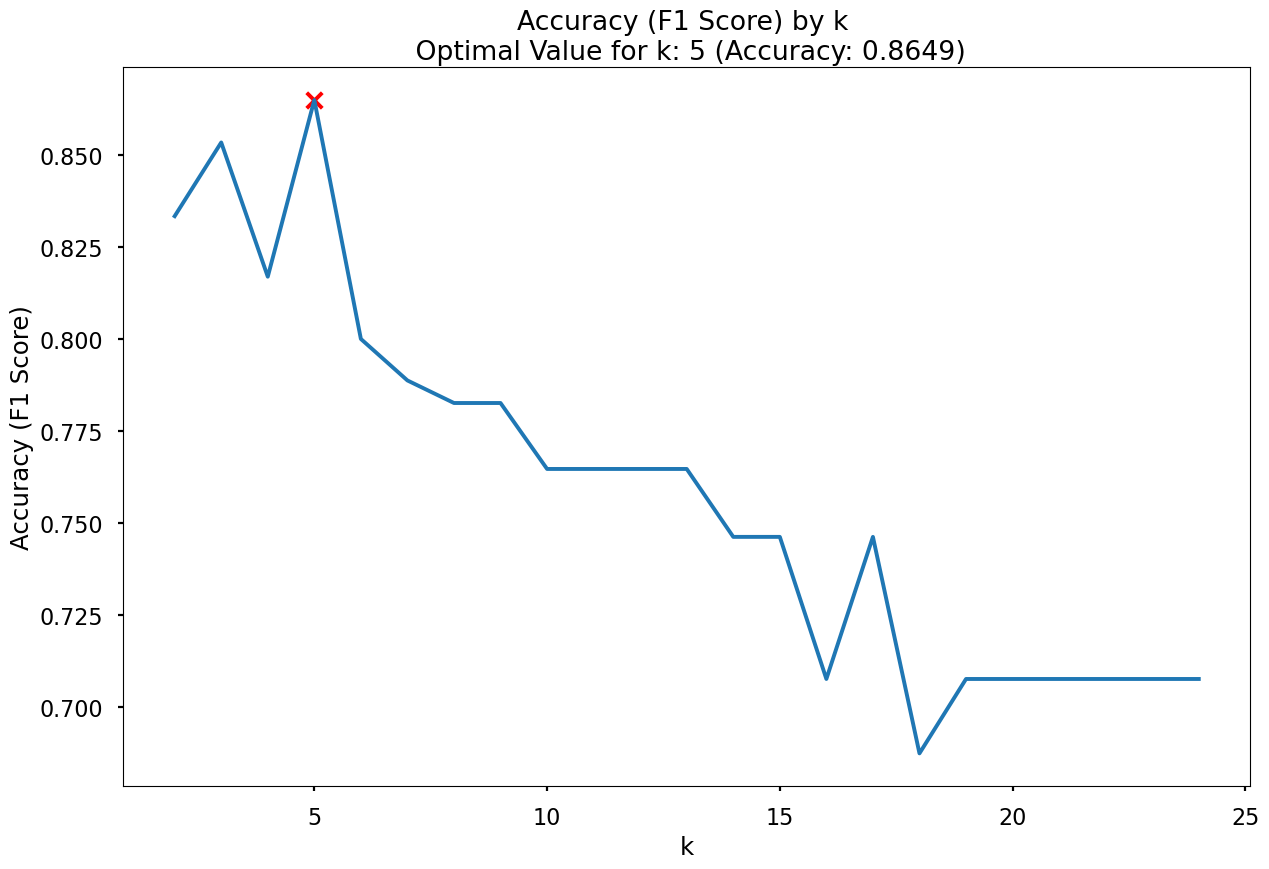

In [241]:
# set up range for search, and empty list to append accuracy scores to
k_list = list(range(2,25))
accuracy_scores = []

# loop through each possible value of k, train and validate model, append test set f1-score
for k in k_list:
    
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test,y_pred)
    accuracy_scores.append(accuracy)
    
# store max accuracy, and optimal k value    
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_k_value = k_list[max_accuracy_idx]

# plot accuracy by max depth
plt.plot(k_list,accuracy_scores)
plt.scatter(optimal_k_value, max_accuracy, marker = "x", color = "red")
plt.title(f"Accuracy (F1 Score) by k \n Optimal Value for k: {optimal_k_value} (Accuracy: {round(max_accuracy,4)})")
plt.xlabel("k")
plt.ylabel("Accuracy (F1 Score)")
plt.tight_layout()
plt.show()

In the plot we can see that the maximum F1-Score on the test set is found when applying a k value of 5 - which is exactly what we started with, so nothing needs to change!

## Modelling Summary

The goal for the project was to build a model that would accurately predict the customers that would sign up for the delivery club. This would allow for a much more targeted approach when running the next iteration of the campaign. A secondary goal was to understand what the drivers for this are, so the client can get closer to the customers that need or want this service, and enhance their messaging.

Based upon these, the chosen the model is the Random Forest as it was a) the most consistently performant on the test set across classication accuracy, precision, recall, and f1-score, and b) the feature importance and permutation importance allows the client an understanding of the key drivers behind delivery club signups.


Metric 1: Classification Accuracy

- KNN = 0.936
- Random Forest = 0.935
- Decision Tree = 0.929
- Logistic Regression = 0.866

Metric 2: Precision

- KNN = 1.00
- Random Forest = 0.887
- Decision Tree = 0.885
- Logistic Regression = 0.784

Metric 3: Recall

- Random Forest = 0.904
- Decision Tree = 0.885
- KNN = 0.762
- Logistic Regression = 0.69

Metric 4: F1 Score

- Random Forest = 0.895
- Decision Tree = 0.885
- KNN = 0.865
- Logistic Regression = 0.734

### Application

We now have a model object, and a the required pre-processing steps to use this model for the next delivery club campaign. When this is ready to launch we can aggregate the neccessary customer information and pass it through, obtaining predicted probabilities for each customer signing up.

Based upon this, we can work with the client to discuss where their budget can stretch to, and contact only the customers with a high propensity to join. This will drastically reduce marketing costs, and result in a much improved ROI.

### Next Steps

While predictive accuracy was relatively high - other modelling approaches could be tested, especially those somewhat similar to Random Forest, for example XGBoost, LightGBM to see if even more accuracy could be gained.

We could even look to tune the hyperparameters of the Random Forest, notably regularisation parameters such as tree depth, as well as potentially training on a higher number of Decision Trees in the Random Forest.

From a data point of view, further variables could be collected, and further feature engineering could be undertaken to ensure that we have as much useful information available for predicting customer loyalty